## Deconvolution

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A better signal model than only a Gaussian spectrum.
  * Background subtraction
  * Acceptance estimate (Current method: a guess based on how the spectra look).

### Load the spectrum from previous notebooks

In [1]:
# Load the NG data and the response function and dump output into variables
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'
with io.capture_output() as output_05:
    %run '05_response function.ipynb'

In [2]:
# You can execute one of these lines if you want to view the output of these scripts
#output_03()
#output_05()

### Define functions

In [3]:
def gaussian(x, mu, sig):
    '''
    Normalized Gaussian function
    '''
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_neutron_spectrum(mu, sigma):
    '''
    Get the smeared version of the response for an original neutron spectrum that is Gaussian in energy.
    Mu and sigma in MeV please.
    Requires globally defined 'neutron_energies', 'electron_energies' and 'response'
    '''
    # The parameter 'electron_energies'  comes from the presupplied response function 
    smeared_response = np.zeros(len(electron_energies))
    
    # Loop over all neutron energy bins expect for last one
    for i in range(len(neutron_energies) - 1):
        # Current neutron energy
        neutron_energy = neutron_energies[i]
        # Current bin width
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        # Current amplitude in the neutron spectrum
        ampl = gaussian(neutron_energy, mu, sigma)
        # Full response for this neutron energy bin
        smeared_response += bin_width*ampl*response[i]
    return smeared_response

def get_neutron_spectrum_interpolated(energy_list, a, mu, sigma):
    '''
    Interpolate the function that we get from 'get_neutron_spectrum'  to fit 'energy_list'
    '''
    smeared_response = get_neutron_spectrum(mu, sigma)
    return a * np.interp(energy_list, 1000*electron_energies, smeared_response)

def get_neutron_spectrum_interpolated_2(energy_list, a1, mu1, sigma1, a2, mu2, sigma2):
    '''
    Two copies of get_neutron_spectrum_interpolated for fitting of two energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2))

def get_neutron_spectrum_interpolated_3(energy_list, 
                                        a1, mu1, sigma1,
                                        a2, mu2, sigma2, 
                                        a3, mu3, sigma3):
    '''
    Three copies of get_neutron_spectrum_interpolated for fitting of three energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    smeared_response3 = get_neutron_spectrum(mu3, sigma3)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2) +
           a3 * np.interp(energy_list, 1000*electron_energies, smeared_response3))

def get_chi_sq(y_data, y_err, y_fit):
    '''
    This function is only used in 'manual minimization' so it is depricated
    '''
    print('DepricationWarning')
    return sum((y_fit - y_data)**2/(y_err**2))

def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    import matplotlib as mpl
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))
    


### Data to fit and definition $\chi^2$ functions

Here are the spectra that we can fit:

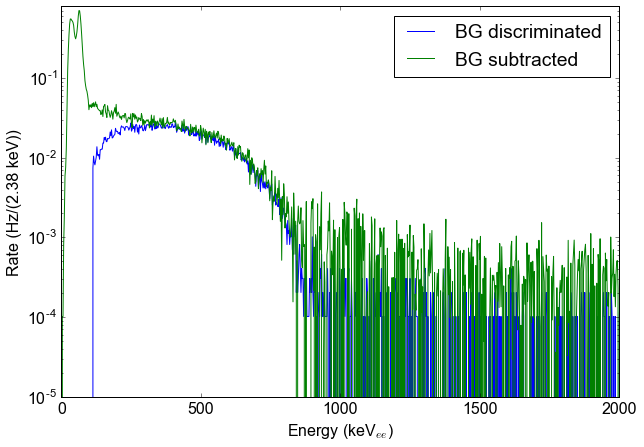

In [4]:
plt.plot(e_scale, fg_0_disc, label='BG discriminated')
plt.plot(e_scale, fg_0_sub, label= 'BG subtracted')
plt.ylabel('Rate (Hz/(2.38 keV))')
plt.yscale('log')
plt.xlim(0,2000)
plt.ylim(0.00001, 0.8)
plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()
plt.show()

In [5]:
from iminuit import Minuit

In [6]:
# Chi^2 function for single Gaussian function in neutron energy
class Chi2Func:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
# Chi^2 function for two Gaussian functions in neutron energy
class Chi2Func_2:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2    

### Settings for fits

In [7]:
min_e = 450
max_e = 900

### Fit background rejected spectrum

In [8]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_0_disc[sel]
y_err = fg_0_disc_err[sel]

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(a=0.3, mu=2.5, sigma=0.5, error_a = 1, error_mu = 1, error_sigma = 1, errordef=1)
# Initialize minimizer and minimize
m_sing_disc = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_sing_disc.migrad();
print(m_sing_disc.values)

FCN = 240.7960152090274 
 TOTAL NCALL = 93 
 NCALLS = 93 
 
 
 EDM = 7.120302290965162e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.296539,0.00340955,0,0,,,
2,mu,2.36763,0.00559183,0,0,,,
3,sigma,0.184907,0.00507233,0,0,,,


{'sigma': 0.18490717761623562, 'mu': 2.3676333452044283, 'a': 0.29653869281354484}


The following cell is depricated. It is to fit a double Gaussian where one is a high-energy component due to 14 MeV neutrons

In [9]:
# # Select the data to fit
# sel = (x3 > 450) & (x3 < 2000)
# x = x3[sel]
# y_data = f3[sel]
# y_err = f3_err[sel]

# # Initialize chi2 function
# chi2 = Chi2FuncFull(x, y_data, y_err)

# # Give guess parameters
# my_args = dict(
#     a1=281, mu1=2.36, sigma1=0.196, error_a1 = 0.1, error_mu1 = 0.1, error_sigma1 = 0.01,
#     a2=79, mu2=16.2, sigma2=0.4, error_a2 = 0.1, error_mu2 = 0.1, error_sigma2 = 0.1)
# # Initialize minimizer and minimize
# m3 = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
# m3.migrad();
# print(m3.values)

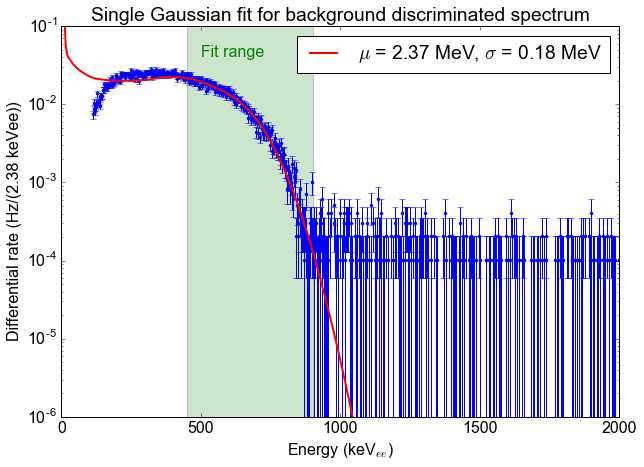

In [10]:
vals = m_sing_disc.values
plt.errorbar(e_scale, fg_0_disc, fg_0_disc_err, ls='None', marker='.')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **vals), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu'], vals['sigma']))

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Single Gaussian fit for background discriminated spectrum')
plt.savefig('plots/fit_spectrum_disc_sing_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

### Fit spectrum for BG subtracted spectrum

We can play the same trick for the spectrum where we subtract background.

In [11]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_0_sub[sel]
y_err = fg_0_sub_err[sel]
assert len(fg_0_sub_err[sel][fg_0_sub_err[sel] == 0]) == 0

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.3, mu=2.4, sigma=0.196, error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)

# m: minimizer; sing: single Gaussian; sub: subtracted the background
m_sing_sub = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_sing_sub.migrad();
print(m_sing_sub.values)

FCN = 202.250424980042 
 TOTAL NCALL = 61 
 NCALLS = 61 
 
 
 EDM = 1.952759912479658e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.328399,0.00649373,0,0,,,
2,mu,2.38397,0.0101483,0,0,,,
3,sigma,0.211899,0.0144858,0,0,,,


{'sigma': 0.21189878260857123, 'mu': 2.3839691145051094, 'a': 0.32839902078477645}


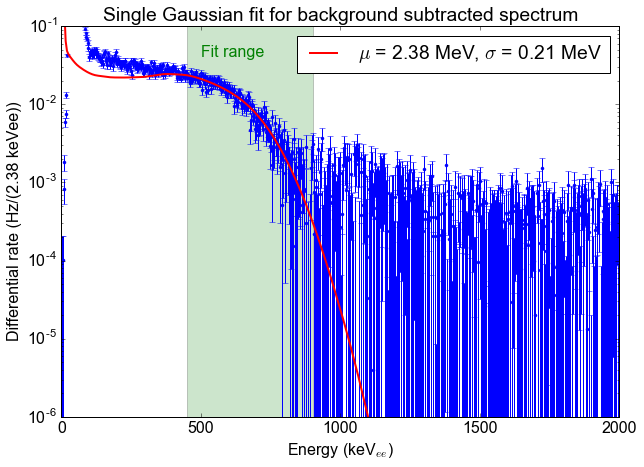

In [12]:
vals = m_sing_sub.values
plt.errorbar(e_scale, fg_0_sub, fg_0_sub_err, ls='None', marker='.')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, **vals), color='red', lw=2,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu'], vals['sigma']))

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Single Gaussian fit for background subtracted spectrum')
plt.savefig('plots/fit_spectrum_sub_sing_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

### Fit double Gaussian

In [13]:
# Select the data to fit
sel = (e_scale > min_e) & (e_scale < max_e)
x = e_scale[sel]
y_data = fg_0_sub[sel]
y_err = fg_0_sub_err[sel]
assert len(fg_0_sub_err[sel][fg_0_sub_err[sel] == 0]) == 0

# Initialize chi2 function
chi2 = Chi2Func_2(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a1=0.15, mu1=2.2, sigma1=0.1, error_a1 = 0.0001, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=0.15, mu2=2.6, sigma2=0.1, error_a2 = 0.0001, error_mu2 = 0.1, error_sigma2 = 0.01,
    errordef=1)
# Initialize minimizer and minimize
m_doub_sub = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m_doub_sub.migrad();
print(m_doub_sub.values)

FCN = 194.14097761563983 
 TOTAL NCALL = 158 
 NCALLS = 158 
 
 
 EDM = 4.7101867679505436e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,0.168525,0.0967311,0,0,,,
2,mu1,2.24765,0.0657583,0,0,,,
3,sigma1,0.0771719,0.0576054,0,0,,,
4,a2,0.151774,0.0958391,0,0,,,
5,mu2,2.56556,0.119796,0,0,,,
6,sigma2,0.119616,0.0874547,0,0,,,


{'a2': 0.15177374218094203, 'mu2': 2.565563366358834, 'sigma2': 0.11961618634417526, 'a1': 0.16852461536592933, 'sigma1': 0.07717194210309589, 'mu1': 2.247646126695561}


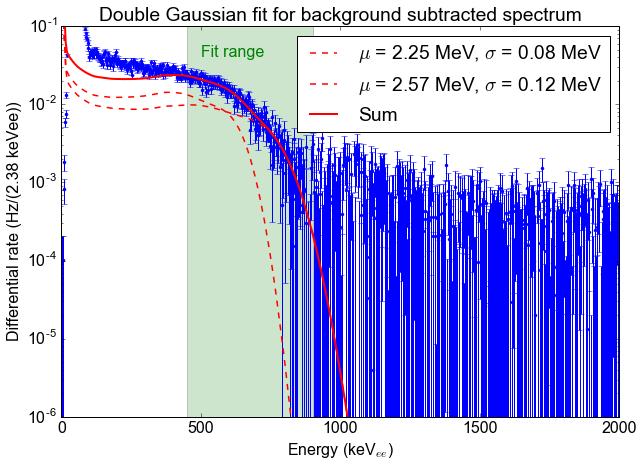

In [14]:
vals = m_doub_sub.values
plt.errorbar(e_scale, fg_0_sub, fg_0_sub_err, ls='None', marker='.')
# Take subplots
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a1'], vals['mu1'], vals['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu1'], vals['sigma1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals['a2'], vals['mu2'], vals['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals['mu2'], vals['sigma2']), ls='--')

plt.plot(e_scale, get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
plt.xlim(0,2000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Double Gaussian fit for background subtracted spectrum')
plt.savefig('plots/fit_spectrum_sub_doub_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

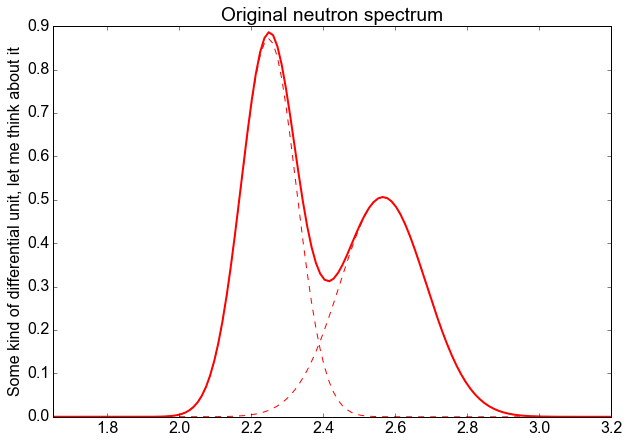

In [15]:
vals = m_doub_sub.values
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, vals['a1']*gaussian(neutron_energies, vals['mu1'],vals['sigma1']) +
         vals['a2']*gaussian(neutron_energies, vals['mu2'],vals['sigma2']),c='red',lw=2)
plt.xlim(1.65, 3.2)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.savefig('plots/neut_spectrum_disc_sing_min_%d_max_%d.png' % (min_e, max_e), bbox_inches='tight')
plt.show()

### High energy population, rebinning method

This is probably the better method to use (other depricated as of July 29, 2016). It is based on the 99 percentile of BG in 50 bins. With this we extend the energy range a lot, all the way down to:

In [25]:
from scipy.integrate import quad

In [26]:
def integrand(x):
    return 50*get_neutron_spectrum_interpolated_2(x, **vals)


In [52]:
# Quick and dirty integration but stilll within % level of scipy.integrate.quad (which is super expensive)
# And: note that it's a correction anyway...
to_sub = []
npoints = 100
for e in e_scale_he:
    e_to_eval = np.linspace(e - 25, e+25, npoints)
    to_sub.append(np.average(integrand(e_to_eval)))
to_sub = np.array(to_sub)

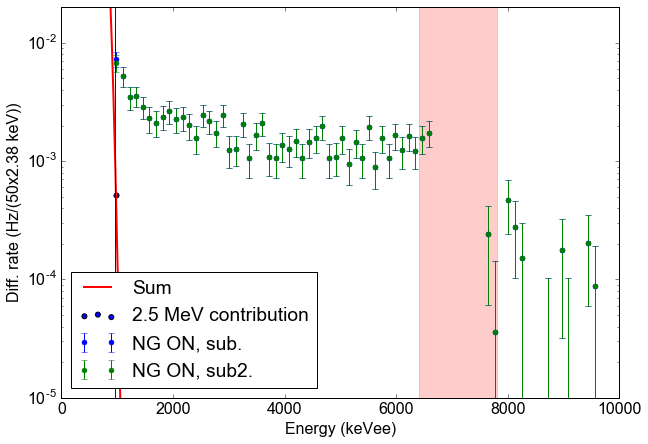

In [74]:
plt.errorbar(e_scale_he,fg_0_he_sub, fg_0_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub.')
plt.errorbar(e_scale_he,fg_0_he_sub-to_sub, fg_0_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub2.')

plt.plot(e_scale, 50*get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')
plt.scatter(e_scale_he,to_sub, marker='.', s=100, label='2.5 MeV contribution')
draw_box((6400,7800),(0,1), color='red', alpha=0.2)
plt.axvline(min(e_scale_he)-25)
plt.ylim(0.00001,0.02)
plt.xlim(0,10000)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Diff. rate (Hz/(50x2.38 keV))')
plt.legend(loc='lower left')
plt.show()

In [110]:
mask = ((e_scale_he <6400) | (e_scale_he > 8000)) & (e_scale_he > 2000)
x = e_scale_he[mask]

y_data = fg_0_he_sub[mask] - to_sub[mask]
y_err = fg_0_he_sub_err
# Set errors to one if entry is zero
for i, ye in enumerate(y_err):
    if ye==0:
        y_err[i] = 1/ng_livetimes_0[0]*1.
        print("WARNING zero entries at %.1f keV" % e_scale_he[i])
y_err = y_err[mask]

(2000.0, 10000.0)

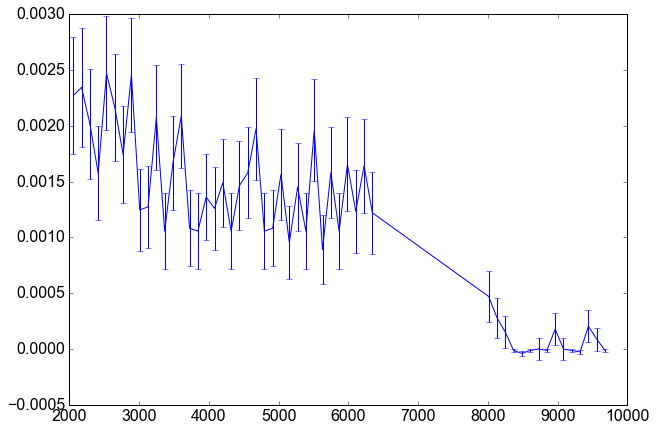

In [111]:
plt.errorbar(x,y_data,y_err)
plt.xlim()

In [112]:
chi2 = Chi2Func(x, y_data, y_err)

In [113]:
# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a=0.4, mu=14, sigma=1., error_a = 0.0001, error_mu = 0.1, error_sigma = 0.01, errordef=1)
# Initialize minimizer and minimize
m_high_2 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m_high_2.migrad();
print(m_high_2.values)

FCN = 51.46349071322431 
 TOTAL NCALL = 388 
 NCALLS = 388 
 
 
 EDM = 0.0001458205514426633 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,0.814297,0.226071,0,0,,,
2,mu,14.1274,0.111107,0,0,,,
3,sigma,0.0158955,0.0362682,0,0,,,


{'sigma': 0.0158954965866253, 'mu': 14.127423224053581, 'a': 0.8142966897411351}


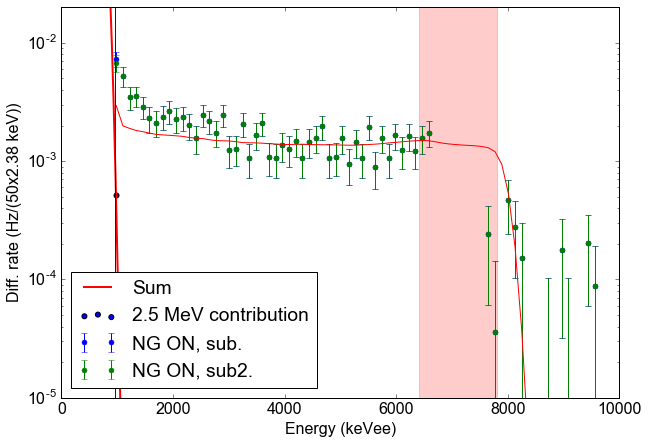

In [114]:
plt.errorbar(e_scale_he,fg_0_he_sub, fg_0_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub.')
plt.errorbar(e_scale_he,fg_0_he_sub-to_sub, fg_0_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub2.')
plt.plot(e_scale_he,get_neutron_spectrum_interpolated(e_scale_he, **m_high_2.values))
plt.plot(e_scale, 50*get_neutron_spectrum_interpolated_2(e_scale, **vals), color='red', lw=2,
        label='Sum')
plt.scatter(e_scale_he,to_sub, marker='.', s=100, label='2.5 MeV contribution')
draw_box((6400,7800),(0,1), color='red', alpha=0.2)
plt.axvline(min(e_scale_he)-25)
plt.ylim(0.00001,0.02)
plt.xlim(0,10000)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Diff. rate (Hz/(50x2.38 keV))')
plt.legend(loc='lower left')
plt.show()




### Combine EVERYTHING

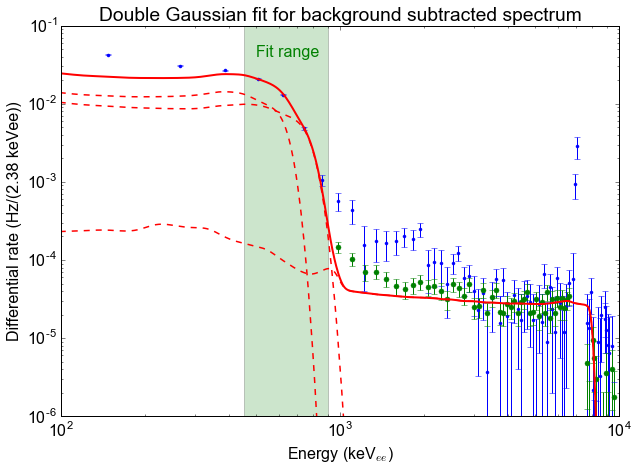

In [126]:
rebin_fac = 50

vals1 = m_doub_sub.values
vals2 = m_high_2.values

# Data (rebinned)
plt.errorbar(rebin(e_scale,rebin_fac), rebin(fg_0_sub,rebin_fac), rebin(fg_0_sub_err,rebin_fac, mode='quad_avg'),
             ls='None', marker='.', label='Background subtracted')
# High energy data
plt.errorbar(e_scale_he, 0.02*fg_0_he_sub, 0.02*fg_0_he_sub_err, ls='None', marker='.', markersize = 10, label='High energy BG rejection')

# Subplots (3 contributions)
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a1'], vals1['mu1'], vals1['sigma1']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals1['mu1'], vals1['sigma1']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, vals1['a2'], vals1['mu2'], vals1['sigma2']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals1['mu2'], vals1['sigma2']), ls='--')
plt.plot(e_scale, get_neutron_spectrum_interpolated(e_scale, 0.02*vals2['a'], vals2['mu'], vals2['sigma']), 
         color='red', lw=1.5,
        label='$\mu$ = %.2f MeV, $\sigma$ = %.2f MeV' % (vals2['mu'], vals2['sigma']), ls='--')

# Full fit
plt.plot(e_scale, get_neutron_spectrum_interpolated_3(e_scale,
                                                     vals1['a1'], vals1['mu1'], vals1['sigma1'],
                                                     vals1['a2'], vals1['mu2'], vals1['sigma2'],
                                                     0.02*vals2['a'], vals2['mu'], vals2['sigma'], 
                                                     ), color='red', lw=2,
        label='Sum')

draw_box((min_e, max_e), (0, 1), facecolor='green', alpha=0.2)
plt.text(500, 0.04, 'Fit range', color='green')

plt.ylim(1e-6,1e-1)
#plt.xlim(0,9000)
plt.xscale('log')
plt.xlim(100.,1e4)
#plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Differential rate (Hz/(2.38 keVee))')
plt.title('Double Gaussian fit for background subtracted spectrum')
plt.show()

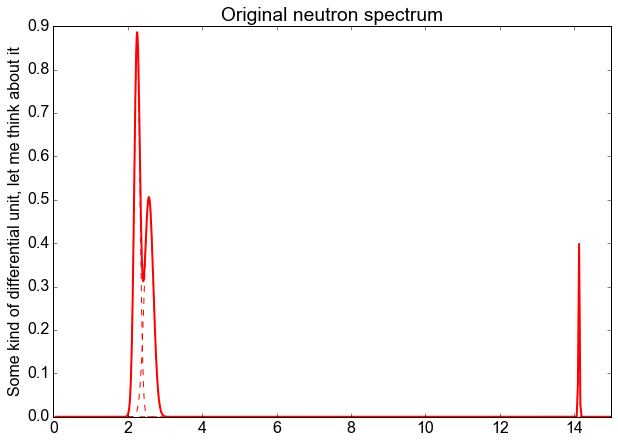

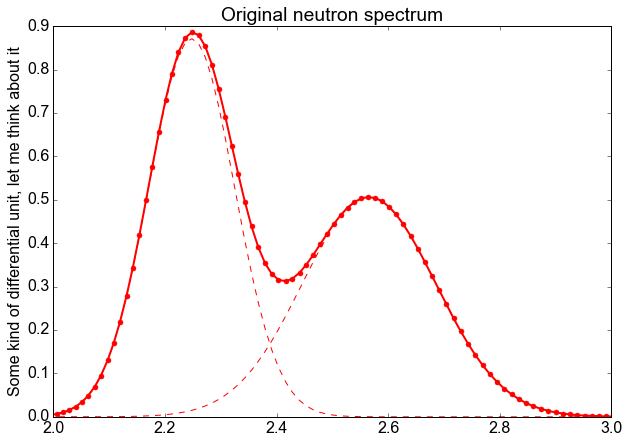

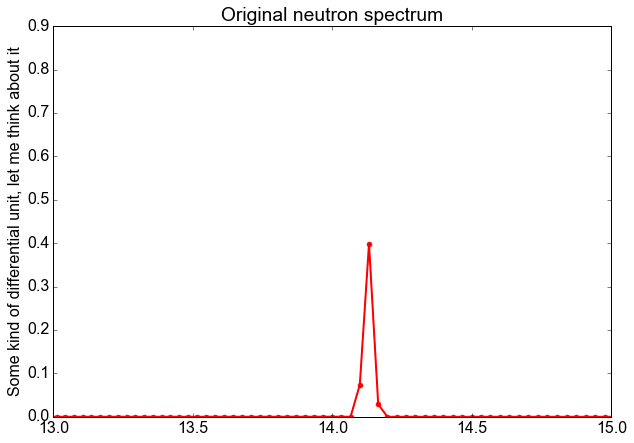

In [123]:
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2)
plt.xlim(0, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2, marker='.', markersize=10)
plt.xlim(2, 3)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']),c='red',ls='--')
plt.plot(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']),c='red',ls='--')
plt.plot(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']) +
         vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']) +
         0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma'])
         ,c='red',lw=2, marker='.', markersize=10)
plt.xlim(13, 15)
plt.ylabel('Some kind of differential unit, let me think about it')
plt.title('Original neutron spectrum')
plt.show()

In [117]:
def int_spec(x, y):
    '''
    Integrate spectrum
    '''
    dx = np.diff(x)
    return sum(y[:-1]*dx)

In [118]:
int_gauss1 = int_spec(neutron_energies, vals1['a1']*gaussian(neutron_energies, vals1['mu1'],vals1['sigma1']))
int_gauss2 = int_spec(neutron_energies,vals1['a2']*gaussian(neutron_energies, vals1['mu2'],vals1['sigma2']))
int_gauss3 = int_spec(neutron_energies, 0.02*vals2['a']*gaussian(neutron_energies, vals2['mu'],vals2['sigma']))
int_tot = int_gauss1 + int_gauss2 + int_gauss3

In [119]:
print('Totals: %.1f%% at %.2f MeV; %.1f%% at %.2f MeV; %.1f%% at %.2f MeV' % 
      (int_gauss1/int_tot*100, vals1['mu1'],
      int_gauss2/int_tot*100, vals1['mu2'],
       int_gauss3/int_tot*100, vals2['mu'],
      ))

Totals: 50.0% at 2.25 MeV; 45.1% at 2.57 MeV; 4.9% at 14.13 MeV
